In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import RFECV, RFE




from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [2]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [4]:
print('Shape: ', df.shape)
#print('Columns:', df.columns)
print(df.info())
display(df.isnull().sum())

Shape:  (1253, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technolog

Timestamp                                                   0
Age                                                        27
Gender                                                     10
City                                                        0
Position                                                    6
Total years of experience                                  16
Years of experience in Germany                             32
Seniority level                                            12
Your main technology / programming language               127
Other technologies/programming languages you use often    157
Yearly brutto salary (without bonus and stocks) in EUR      0
Yearly bonus + stocks in EUR                              424
Number of vacation days                                    68
Employment status                                          17
Сontract duration                                          29
Main language at work                                      16
Company 

In [5]:
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

<h1>Answers and Explainations
(Expand/modify as needed)

In [6]:
# Create Functions

# function to drop columns not needed
def drop_col(data, column):
    data.drop(columns=[column], axis=1, inplace=True)
    return data.columns

# function to Investigate column: print out unique values; nullvalues; and value count based on nsmallest @ 20
def Explore(data, column):
    print('Unique Values: ', data[column].nunique())
    print('Null Values:',data[column].isnull().sum())
    print('Type: ', data[column].dtype)
    display(data[column].value_counts().nsmallest(n=20)) # display value_counts() with nsmallest set at 20
    return

# Function to replace column names to new name
def replace_colmnNAME(data, column, new):
    data.columns = data.columns.str.replace(f'{column}', f'{new}')
    #data.columns
    return
    
# Function to fill null values with MODE()
# Since we are dealing with Age to predict Salary, we can use the median Age to replace the Null Values.
def fill_Null_mode(data, column):
    data[column].fillna(data[column].mode()[0], inplace=True)
    print(f'Null vales in {column}: ', data[column].isnull().sum())
    return

# Function to fill null values with MEAN()
# Since we are dealing with Age to predict Salary, we can use the median Age to replace the Null Values.
def fill_Null_mean(data, column):
    method=data[column].mean()
    data[column].fillna(value=method, inplace=True)
    print(f'Null vales in {column}: ',data[column].isnull().sum())
    return

# Function to fill null values with MEDIAN()
# Since we are dealing with Age to predict Salary, we can use the median Age to replace the Null Values.
def fill_Null_median(data, column):
    method=data[column].median()
    data[column].fillna(value=method, inplace=True)
    print(f'Null vales in {column}: ',data[column].isnull().sum())
    return

# Function to replace Null Values with 0
def fill_Null_Zero(data, column):
    data[column] = data[column].fillna(0)
    print('Null Values in Converted column: ', data[column].isnull().sum())
    return

# Function to fill the null values by 50% Most Popular and 50% by 2nd most Popular
# from: https://stackoverflow.com/questions/39066260/get-first-and-second-highest-values-in-pandas-columns
def fill_by_Mostpop_secndPop(data, column):
    #Index the Most popular and 2nd most popular values
    Popular=data[column].value_counts().index[:2][0] # Looking at the top two results: then take the index value at first popular
    Popular2=data[column].value_counts().index[:2][1] # second Index for 2nd most popular value
    #Fill 50% with most popular
    idx=data.index[data[column].isna()]# Find initial number of nulls
    data.loc[np.random.choice(idx, size=int(len(idx)/2), replace=False), f'{column}']=Popular
    #Fill remaining nulls with 2nd most popular
    idx2=data.index[data[column].isna()] # finds the remaining number of nulls
    data.loc[np.random.choice(idx2, size=int(len(idx2)), replace=False), f'{column}']=Popular2
    #print the Null Values 
    print('Null Values:',data[column].isnull().sum())
    return

# Function to replace ',' to '.' in column
def string_replace(data, column):
    data[column] = df[column].str.replace(',','.')
    print('Null Values:',data[column].isnull().sum())
    display(data[column].value_counts().nsmallest(n=20))
    return
    

# function to Convert Column to Numeric using errors='coerce'
# pandas.to_numeric(errors=''): If ‘coerce’, then invalid parsing will be set as NaN.
# https://sparkbyexamples.com/pandas/pandas-convert-string-to-float-type-dataframe/
def convert_to_Num(data, column):
    data[column]=pd.to_numeric(data[column], errors='coerce')
    return print(f'Null Values in {column}: ', data[column].isnull().sum()), print(data[column].dtype)
    

# Convert columns from Object to Categorical:
# Advatneges: https://www.kaggle.com/questions-and-answers/251302
def Conver_to_Cat(data, column):
    #data[column]=data[column].astype('category')
    data[column]=pd.Categorical(data[column])
    return

# Function to transform y to np.log(y) for TransformedTargetRegressor
def log_transformer(y):
    return np.log(y)

# Part 1: Data Wrangling / Data Cleaning

In [7]:
# We dont know what timestamp represedf.nts here: Need to drop this column.
drop_col(df, 'Timestamp')

Index(['Age', 'Gender', 'City', 'Position ', 'Total years of experience',
       'Years of experience in Germany', 'Seniority level',
       'Your main technology / programming language',
       'Other technologies/programming languages you use often',
       'Yearly brutto salary (without bonus and stocks) in EUR',
       'Yearly bonus + stocks in EUR', 'Number of vacation days',
       'Employment status', 'Сontract duration', 'Main language at work',
       'Company size', 'Company type'],
      dtype='object')

In [8]:
# Rename columns: they are just too long
replace_colmnNAME(df, 'Position ', 'Position')
replace_colmnNAME(df, 'Total years of experience', 'Total_yrs_Exp')
replace_colmnNAME(df, 'Years of experience in Germany', 'German_Exp')
replace_colmnNAME(df, 'Seniority level', 'Seniority_level')
replace_colmnNAME(df, 'Your main technology / programming language', 'Main_Backgrnd')
replace_colmnNAME(df, 'Other technologies/programming languages you use often', 'Other_Backgrnd')
#replace_colmnNAME(df, 'Yearly brutto salary (without bonus and stocks) in EUR', 'Yearly_Salary_EUR')
#replace_colmnNAME(df, 'Yearly bonus + stocks in EUR', 'Yearly_Bonus_EUR')
replace_colmnNAME(df, 'Number of vacation days', 'Vac_days')
replace_colmnNAME(df, 'Employment status', 'Empl_Status')
replace_colmnNAME(df, 'Сontract duration', 'Contract_duration')
replace_colmnNAME(df, 'Main language at work', 'Main_Work_Lang')
replace_colmnNAME(df, 'Company size', 'Company_size')
replace_colmnNAME(df, 'Company type', 'Company_type')

In [9]:
df.columns

Index(['Age', 'Gender', 'City', 'Position', 'Total_yrs_Exp', 'German_Exp',
       'Seniority_level', 'Main_Backgrnd', 'Other_Backgrnd',
       'Yearly brutto salary (without bonus and stocks) in EUR',
       'Yearly bonus + stocks in EUR', 'Vac_days', 'Empl_Status',
       'Contract_duration', 'Main_Work_Lang', 'Company_size', 'Company_type'],
      dtype='object')

### Create Target Variable
<li> df[Target]= df[Yearly brutto salary (without bonus and stocks) in EUR] + df[Yearly bonus + stocks in EUR]

<il>Column: Yearly brutto salary (without bonus and stocks) in EUR

In [10]:
Explore(df, 'Yearly brutto salary (without bonus and stocks) in EUR')

Unique Values:  201
Null Values: 0
Type:  float64


49200.0        1
25300.0        1
106000.0       1
21000.0        1
77250.0        1
94000.0        1
56700.0        1
66500.0        1
91000.0        1
67473.0        1
172000.0       1
81500.0        1
500000000.0    1
52800.0        1
151872.0       1
33000.0        1
240000.0       1
850000.0       1
11000.0        1
85600.0        1
Name: Yearly brutto salary (without bonus and stocks) in EUR, dtype: int64

<AxesSubplot:xlabel='Yearly brutto salary (without bonus and stocks) in EUR'>

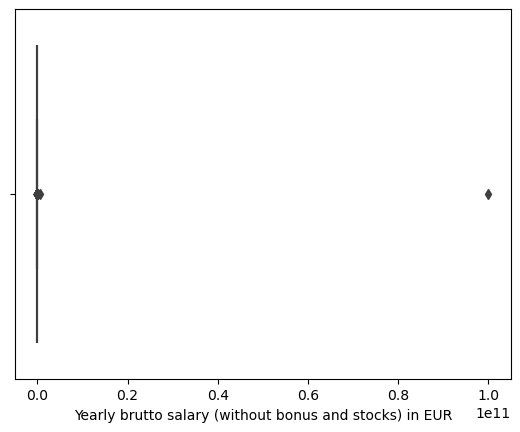

In [11]:
sns.boxplot(x=df['Yearly brutto salary (without bonus and stocks) in EUR'])

In [12]:
df['Yearly brutto salary (without bonus and stocks) in EUR'].value_counts()

6.000000e+04    85
7.000000e+04    83
6.500000e+04    77
7.500000e+04    73
8.000000e+04    66
                ..
1.000000e+11     1
3.400000e+04     1
7.930000e+04     1
6.630000e+04     1
3.835000e+04     1
Name: Yearly brutto salary (without bonus and stocks) in EUR, Length: 201, dtype: int64

### oooofffffff too many outliers

<AxesSubplot:xlabel='Yearly brutto salary (without bonus and stocks) in EUR'>

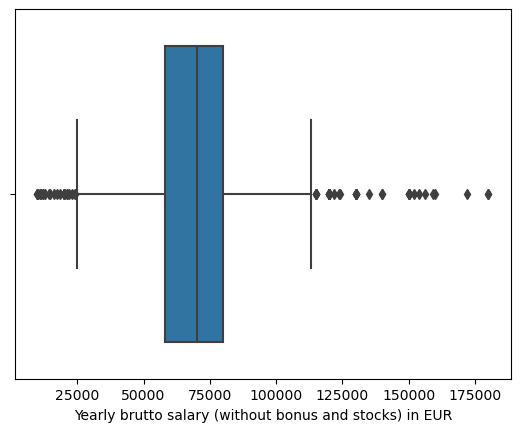

In [13]:
# lets limit yearly salary to a "realistic" limit
ex=df.loc[df['Yearly brutto salary (without bonus and stocks) in EUR']<185000]
sns.boxplot(x=ex['Yearly brutto salary (without bonus and stocks) in EUR'])

In [14]:
# how much of the dataframe do we loose if we put a limit on the Yearly Salary?
display(ex.shape)
display(df.shape)

(1243, 17)

(1253, 17)

In [15]:
# We will loose only 10 rows (0.8% of the dataframe-pretty good) if we limit the Yearly Salary to $185000

df_new=df[df['Yearly brutto salary (without bonus and stocks) in EUR']<185000]
#df_new=df[df['Yearly brutto salary (without bonus and stocks) in EUR']<220000]
df_new=df_new.copy()

In [16]:
Explore(df_new, 'Yearly brutto salary (without bonus and stocks) in EUR')

Unique Values:  194
Null Values: 0
Type:  float64


62500.0     1
106000.0    1
49200.0     1
25300.0     1
84700.0     1
21000.0     1
66500.0     1
77250.0     1
50500.0     1
56700.0     1
108500.0    1
91000.0     1
67473.0     1
94000.0     1
81500.0     1
52800.0     1
151872.0    1
33000.0     1
11000.0     1
85600.0     1
Name: Yearly brutto salary (without bonus and stocks) in EUR, dtype: int64

<AxesSubplot:xlabel='Yearly brutto salary (without bonus and stocks) in EUR', ylabel='Count'>

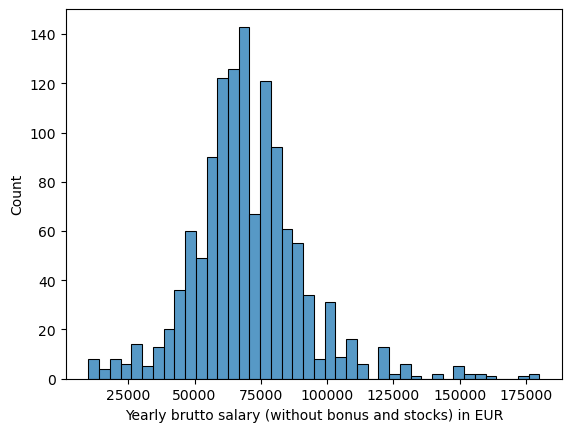

In [17]:
sns.histplot(data=df_new, x='Yearly brutto salary (without bonus and stocks) in EUR')

#### We reduced the null values from 201 to 194: not bad and hisplot shows a somewhat "good even bell curve".

In [18]:
# we can now fill the null values with the mean() of the yearly salary.
fill_Null_mean(df_new, 'Yearly brutto salary (without bonus and stocks) in EUR')

Null vales in Yearly brutto salary (without bonus and stocks) in EUR:  0


<il>Column: Yearly bonus + stocks in EUR

In [19]:
Explore(df_new, 'Yearly bonus + stocks in EUR')

Unique Values:  165
Null Values: 422
Type:  object


71000       1
67000       1
106000      1
Na          1
43000       1
4400        1
87250       1
21000       1
84000       1
66500       1
3250        1
37968       1
1100        1
97000       1
3600        1
23000       1
6710        1
depends     1
60847.32    1
66447       1
Name: Yearly bonus + stocks in EUR, dtype: int64

In [20]:
# whats the most popular?
print(df_new['Yearly bonus + stocks in EUR'].mode()[0])

0


In [21]:
# Convert Column to numeric()
convert_to_Num(df_new, 'Yearly bonus + stocks in EUR')

Null Values in Yearly bonus + stocks in EUR:  427
float64


(None, None)

In [22]:
df_new['Yearly bonus + stocks in EUR'].value_counts().head(10)

0.0        227
5000.0      56
10000.0     45
2000.0      36
6000.0      26
3000.0      23
1000.0      23
20000.0     21
4000.0      18
7000.0      15
Name: Yearly bonus + stocks in EUR, dtype: int64

In [23]:
# there are 227 Values that represent $0 Bonus. The next most popular is $5000 @ 56
# should we replace null values with just the most popular or should we populate the null values by 50%: $0 and 50% $5000
# I think in this case, we should fill null values with the most popular: $0 since the ratio of 0 values is huge
# in reality, as we see below at column Position, there are 80 that are are entry level.

In [24]:
# Fill null values with zero as most people in the dataframe did not receive any extra money beyond their basic salary.
fill_Null_Zero(df_new, 'Yearly bonus + stocks in EUR')

Null Values in Converted column:  0


<AxesSubplot:xlabel='Yearly bonus + stocks in EUR'>

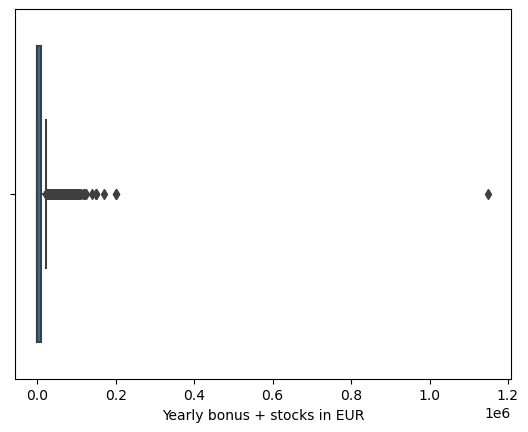

In [25]:
sns.boxplot(x=df_new['Yearly bonus + stocks in EUR'])

<AxesSubplot:xlabel='Yearly bonus + stocks in EUR', ylabel='Count'>

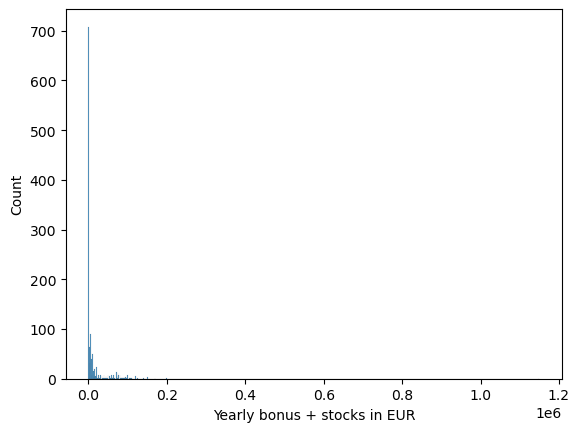

In [26]:
sns.histplot(data=df_new, x='Yearly bonus + stocks in EUR')

Pretty normal since most of the candidates did not have a bonus.

In [27]:
# Create Target
df_new['Target']=df_new['Yearly brutto salary (without bonus and stocks) in EUR'] + df_new['Yearly bonus + stocks in EUR']

# drop the columns as we do not need them anymore once we create the calculated Target column
drop_col(df_new, 'Yearly bonus + stocks in EUR')
drop_col(df_new, 'Yearly brutto salary (without bonus and stocks) in EUR')

# Did it work?
df_new.head(2)

,Age,Gender,City,Position,Total_yrs_Exp,German_Exp,Seniority_level,Main_Backgrnd,Other_Backgrnd,Vac_days,Empl_Status,Contract_duration,Main_Work_Lang,Company_size,Company_type,Target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0


### Investigate our new 'Target' column

In [28]:
df_new['Target'].describe()

count    1.243000e+03
mean     8.347929e+04
std      5.062216e+04
min      1.000100e+04
25%      6.000000e+04
50%      7.300000e+04
75%      9.000000e+04
max      1.240000e+06
Name: Target, dtype: float64

<AxesSubplot:xlabel='Target'>

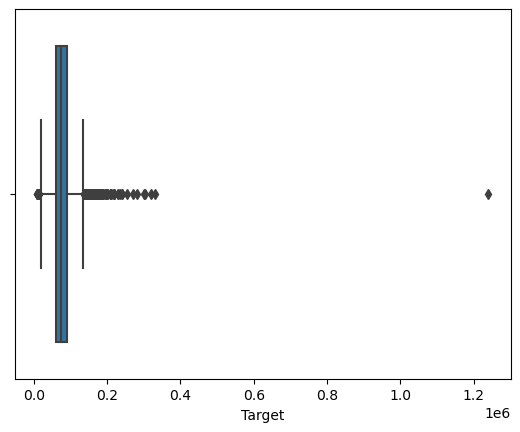

In [29]:
sns.boxplot(x=df_new['Target'])

<AxesSubplot:xlabel='Target', ylabel='Count'>

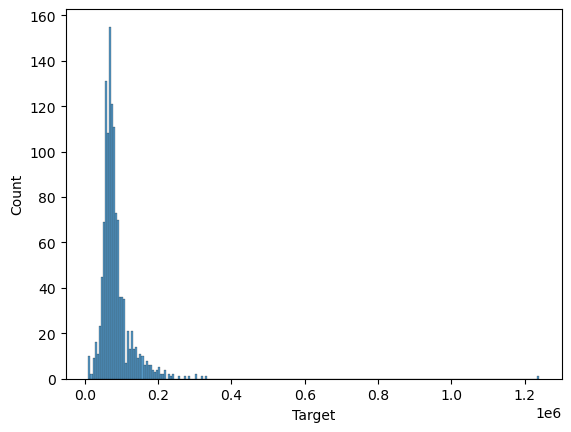

In [30]:
sns.histplot(data=df_new, x='Target')

In [31]:
df_new['Target'].min()

10001.0

In [32]:
# The Target column is highly skewed: We may need to re-generate the model with the LOG variant of our Target.

In [33]:
# Now lets look at the rest of the columns:

### Column: Age

In [34]:
Explore(df_new, 'Age')

Unique Values:  39
Null Values: 26
Type:  float64


53.0     1
65.0     1
66.0     1
50.0     1
51.0     1
21.0     1
59.0     1
69.0     1
52.0     1
54.0     2
49.0     2
56.0     2
47.0     3
48.0     4
22.0     8
44.0     8
46.0     8
45.0    10
43.0    10
23.0    12
Name: Age, dtype: int64

In [35]:
# Since we are dealing with Age to predict Salary, we can use the median Age to replace the Null Values.
fill_Null_median(df_new, 'Age')

Null vales in Age:  0


<AxesSubplot:xlabel='Age', ylabel='Count'>

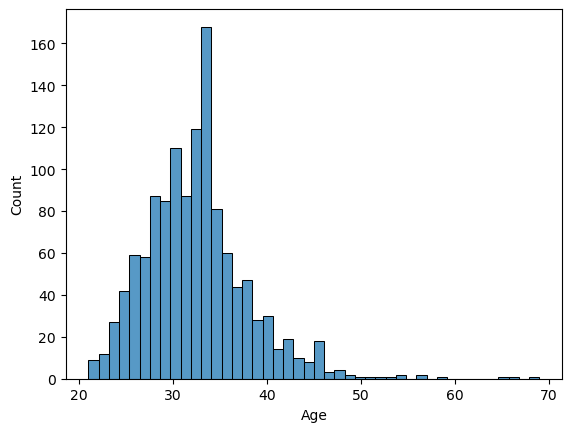

In [36]:
sns.histplot(data=df_new, x='Age')

### Column: Gender

In [37]:
Explore(df_new, 'Gender')

Unique Values:  3
Null Values: 9
Type:  object


Diverse       2
Female      191
Male       1041
Name: Gender, dtype: int64

In [38]:
# To get rid of Bias; we fill half the null values witht he most popular and remaining with the 2nd most popular.
fill_by_Mostpop_secndPop(df_new, 'Gender')

Null Values: 0


<AxesSubplot:xlabel='Gender', ylabel='count'>

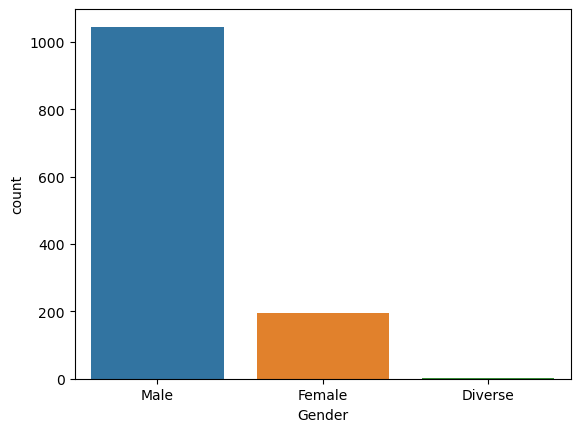

In [39]:
sns.countplot(data=df_new, x='Gender')

In [40]:
# For Gender Column, we have 10 missing values with 3 unique values
# We can replace the null values with the most common category using .mode()
# Generally mode is the best way to fill null values in Categorical columns.
#fill_Null_mode(df_new, 'Gender')

### Column: City

In [41]:
German_Cities=['Berlin','Hamburg','Munich', 'München','Cologne' ,'Köln','Frankfurt', 'Frankfurt am Main','Frankfurt','Stuttgart',
'Düsseldorf','Dortmund','Essen','Leipzig','Bremen','Dresden','Hanover','Hannover','Nuremberg' ,'Nürnberg','Nurnberg','Duisburg','Bochum','Wuppertal',
'Bielefeld','Bonn','Münster','Karlsruhe','Mannheim','Augsburg','Wiesbaden','Gelsenkirchen','Mönchengladbach','Monchengladbach','Braunschweig','Chemnitz','Kiel',
'Aachen','Halle', 'Saale','Magdeburg','Freiburg im Breisgau','Krefeld','Lübeck','Lubeck','Oberhausen','Erfurt','Mainz','Rostock','Kassel','Hagen','Hamm',
'Saarbrücken','Saarbrucken','Mülheim an der Ruhr','Potsdam','Ludwigshafen am Rhein','Oldenburg','Leverkusen','Osnabrück','Osnabruck','Solingen','Heidelberg','Herne',
'Neuss','Darmstadt','Paderborn','Regensburg','Ingolstadt','Würzburg','Wurzburg','Fürth','Wolfsburg','Offenbach am Main','Ulm','Heilbronn','Pforzheim','Göttingen','Gottingen','Bottrop','Trier',
'Recklinghausen','Reutlingen','Bremerhaven','Koblenz','Bergisch Gladbach','Jena','Remscheid','Erlangen','Moers',
'Siegen','Hildesheim','Salzgitter']

In [42]:
Explore(df_new, 'City')

Unique Values:  118
Null Values: 0
Type:  object


Brussels                 1
Dublin                   1
Copenhagen               1
Sevilla                  1
Brunswick                1
City in Russia           1
Cracow                   1
Krakow                   1
Ingolstadt               1
Jena                     1
Dortmund                 1
Heilbronn                1
Warsaw, Poland           1
Sofia                    1
Brussels                 1
Cambridge                1
Hildesheim               1
Zürich                   1
Murnau am Staffelsee     1
Prefer not to say        1
Name: City, dtype: int64

In [43]:
# Function to Map and group the various Cities into From_Germany or Outside_Germany
def map_function5(value):
    if value in German_Cities:
        return "From_Germany"
    else:
        return "Outside_Germany"

#df_new['City'] = df_new["City"].apply(lambda x: x.split()[0]).map(map_function5) #just incase, people entered two values, we always take the first City entered.
df_new['City'] = df_new["City"].map(map_function5)

In [44]:
df_new['City'].value_counts()

From_Germany       1100
Outside_Germany     143
Name: City, dtype: int64

<AxesSubplot:xlabel='City', ylabel='count'>

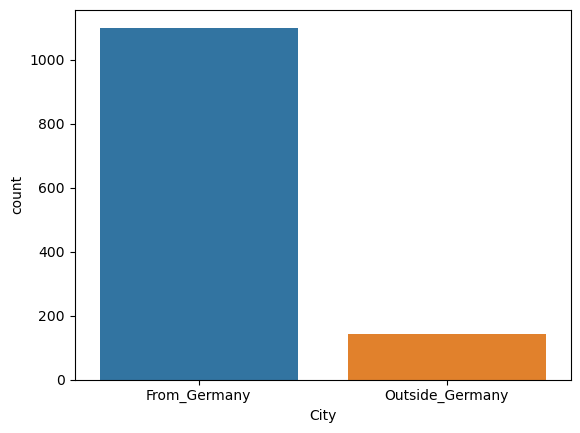

In [45]:
sns.countplot(data=df_new, x='City')

### Column: Position

In [46]:
Explore(df_new, 'Position')

Unique Values:  147
Null Values: 5
Type:  object


Security engineer                   1
support engineer                    1
Technical project manager           1
Head of BI                          1
Senior Scrum Master (RTE)           1
BI Developer / Data Engineer        1
BI Analyst                          1
Project manager                     1
working student (QA)                1
Tech recruiting                     1
data engineer                       1
Architect                           1
Head of IT                          1
Analyst                             1
Senior Data Engineer                1
Teamlead                            1
Dana Analyst                        1
Big Data Engineer                   1
computer vision researcher          1
BI Consultant SAP/ Data Engineer    1
Name: Position, dtype: int64

In [47]:
df_new['Position'].tail(40)

1212                        Frontend Developer
1213                         Software Engineer
1214                         Backend Developer
1215                         Software Engineer
1216                         Backend Developer
1217                         Backend Developer
1218                         Software Engineer
1219                          Mobile Developer
1220                         Software Engineer
1221                        Software Architekt
1222                         Software Engineer
1224                         Backend Developer
1225                        Frontend Developer
1226                         Software Engineer
1227                        Frontend Developer
1228                         Software Engineer
1229                               ML Engineer
1230                         Software Engineer
1231                                       NaN
1232                         Software Engineer
1233                               Testmanager
1234         

In [48]:
# we have 6 null values and 148 unique instances.
# To get rid of Bias; we fill half the null values witht he most popular and remaining with the 2nd most popular.
fill_by_Mostpop_secndPop(df_new, 'Position')

Null Values: 0


In [49]:
# Function to Map and grouo the various Position Titles into Software Engineer, Software Developer etc.
def map_function(value):
    if value in ["Engineer", 'Developer']:
        return "Software Engineer/Developer"
    elif value in ['Analyst']:
        return "Data Analyst"
    elif value in ["Scientist"]:
        return "Data Scientist"
    elif value in ["Manager"]:
        return "IT Manager"
    elif value == "Devops":
        return "Devops"
    else:
        return "Other"

df_new['Position'] = df_new["Position"].apply(lambda x: x.split()[-1]).map(map_function) # maps to the second index of the title

In [50]:
df_new['Position'].value_counts()

Software Engineer/Developer    870
Other                          177
Data Scientist                 109
IT Manager                      67
Data Analyst                    20
Name: Position, dtype: int64

<AxesSubplot:xlabel='Position', ylabel='count'>

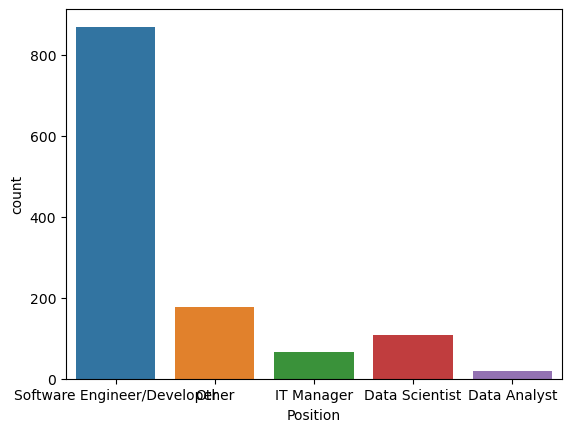

In [51]:
sns.countplot(data=df_new, x='Position')

### Column: Total_yrs_Exp

In [52]:
Explore(df_new, 'Total_yrs_Exp')

Unique Values:  48
Null Values: 15
Type:  object


383                                                    1
6 (not as a data scientist, but as a lab scientist)    1
31                                                     1
15, thereof 8 as CTO                                   1
2,5                                                    1
1 (as QA Engineer) / 11 in total                       1
5.5                                                    1
24                                                     1
29                                                     1
28                                                     1
7.5                                                    1
6.5                                                    1
40                                                     1
26                                                     1
less than year                                         1
1,5                                                    2
27                                                     2
3.5                            

In [53]:
# Replace the ',' between the characters with '.'
string_replace(df_new, 'Total_yrs_Exp')

Null Values: 15


6 (not as a data scientist. but as a lab scientist)    1
31                                                     1
15. thereof 8 as CTO                                   1
1 (as QA Engineer) / 11 in total                       1
383                                                    1
5.5                                                    1
24                                                     1
29                                                     1
28                                                     1
7.5                                                    1
6.5                                                    1
26                                                     1
40                                                     1
less than year                                         1
23                                                     2
4.5                                                    2
3.5                                                    2
0.8                            

In [54]:
# Convert the column to Numerical
convert_to_Num(df_new, 'Total_yrs_Exp')

Null Values in Total_yrs_Exp:  19
float64


(None, None)

In [55]:
# fill null values with mean
fill_Null_mean(df_new, 'Total_yrs_Exp')

Null vales in Total_yrs_Exp:  0


<AxesSubplot:xlabel='Total_yrs_Exp', ylabel='Count'>

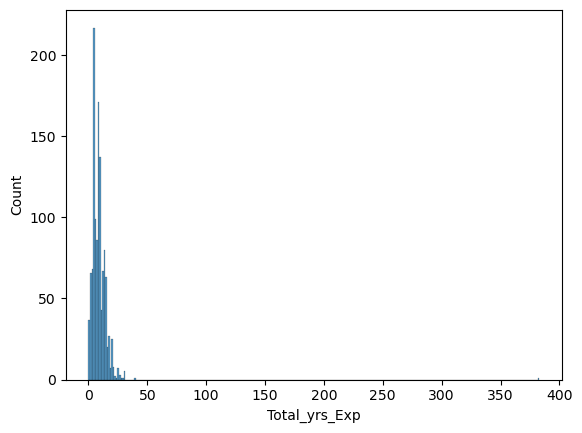

In [56]:
sns.histplot(data=df_new, x='Total_yrs_Exp')

### # Column: German_Exp

In [57]:
Explore(df_new, 'German_Exp')

Unique Values:  53
Null Values: 31
Type:  object


3 months                                               1
⁰                                                      1
<1                                                     1
3 (in Poland)                                          1
0,3                                                    1
-                                                      1
2.6                                                    1
0.1                                                    1
4.5                                                    1
6 (not as a data scientist, but as a lab scientist)    1
0.2                                                    1
4 (in Switzerland), 0 (in Germany)                     1
26                                                     1
4 month                                                1
17                                                     1
16                                                     1
< 1                                                    1
25                             

In [58]:
string_replace(df_new, 'German_Exp')

Null Values: 31


6 (not as a data scientist. but as a lab scientist)    1
-                                                      1
0.3                                                    1
⁰                                                      1
3 months                                               1
<1                                                     1
3 (in Poland)                                          1
2.6                                                    1
0.1                                                    1
0.2                                                    1
1.7                                                    1
26                                                     1
4 month                                                1
17                                                     1
16                                                     1
4 (in Switzerland). 0 (in Germany)                     1
< 1                                                    1
25                             

In [59]:
convert_to_Num(df_new, 'German_Exp')

Null Values in German_Exp:  41
float64


(None, None)

In [60]:
# Fill null values with median
fill_Null_median(df_new, 'German_Exp')

Null vales in German_Exp:  0


<AxesSubplot:xlabel='German_Exp', ylabel='Count'>

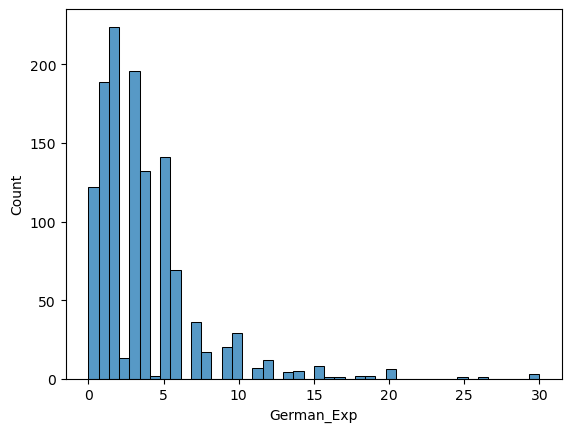

In [61]:
sns.histplot(data=df_new, x='German_Exp')

### # Column: Seniority_level

In [62]:
Explore(df_new, 'Seniority_level')

Unique Values:  22
Null Values: 11
Type:  object


Intern                                         1
Entry level                                    1
Working Student                                1
C-Level                                        1
no idea, there are no ranges in the firm       1
Student                                        1
intern                                         1
Key                                            1
C-level executive manager                      1
Director                                       1
No level                                       1
Work Center Manager                            1
Manager                                        1
VP                                             1
No level                                       1
student                                        1
Principal                                      3
Head                                          43
Junior                                        78
Lead                                         164
Name: Seniority_leve

In [63]:
# To get rid of Bias; we fill half the null values with the most popular and remaining half with the 2nd most popular.
fill_by_Mostpop_secndPop(df_new, 'Seniority_level')

Null Values: 0


In [64]:
df_new['Seniority_level'].value_counts().head(30)

Senior                                       568
Middle                                       371
Lead                                         164
Junior                                        78
Head                                          43
Principal                                      3
Intern                                         1
Entry level                                    1
Working Student                                1
C-Level                                        1
no idea, there are no ranges in the firm       1
Student                                        1
intern                                         1
Key                                            1
C-level executive manager                      1
Director                                       1
No level                                       1
Work Center Manager                            1
Manager                                        1
VP                                             1
No level            

In [65]:
def map_function2(value):
    if value in ['Intern', 'Entry Level', 'Working Student', 'Student', 'student', 'intern', 'Junior', 'junior' ]:
        return "Junior"
    elif value in ['Senior', 'Lead', 'Head', 'Principal', 'C-Level', 'Key', 'C-level executive manager', 'Director', 'Manager', 'VP', 'Work Center Manager']:
        return "Senior"
    elif value in ["Middle"]:
        return "Middle"
    else:
        return "Other"

df_new["Seniority_level"] = df_new["Seniority_level"].map(map_function2)

In [66]:
df_new['Seniority_level'].value_counts()

Senior    785
Middle    371
Junior     83
Other       4
Name: Seniority_level, dtype: int64

<AxesSubplot:xlabel='Seniority_level', ylabel='count'>

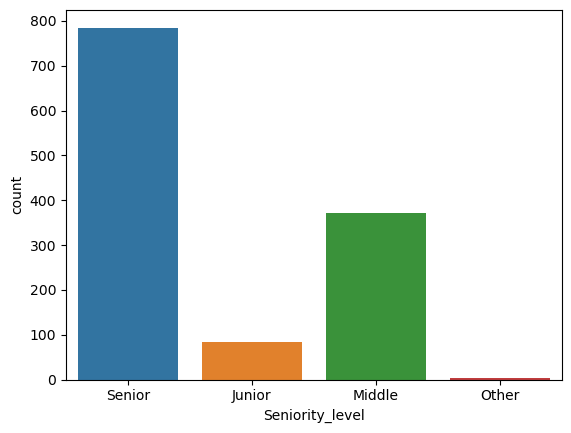

In [67]:
sns.countplot(data=df_new, x='Seniority_level')

### Column: Main_Backgrnd

In [68]:
Explore(df_new, 'Main_Backgrnd')

Unique Values:  252
Null Values: 126
Type:  object


C++, C#                          1
Kotlin/PHP                       1
Java Backend                     1
SAP ABAP                         1
AI                               1
pythin                           1
Java & PHP                       1
Pyrhon                           1
C++/c                            1
Angular, Typescript              1
TypeScript/Angular               1
PM tools                         1
Grails, Groovy                   1
python                           1
Python, database technologies    1
React / JavaScript               1
Perl                             1
Python, cloud computing          1
golang                           1
swift                            1
Name: Main_Backgrnd, dtype: int64

In [69]:
df_new['Main_Backgrnd'].value_counts().head(20)

Java          183
Python        164
PHP            56
C++            37
JavaScript     34
Javascript     31
C#             29
python         26
Scala          24
Go             23
Swift          23
Kotlin         22
Python         21
Ruby           19
SQL            14
TypeScript     14
.NET           13
JS             12
iOS            10
R               9
Name: Main_Backgrnd, dtype: int64

In [70]:
df_new['Main_Backgrnd'].mode()[0]

'Java'

In [71]:
# Due to my lack of domain knowleadge of the IT industry,I have decided to group the column values as below:
def map_function2(value):
    if value in ['Java', 'JavaScript', 'Javascript', 'JS', 'Java Backend', 'Java & PHP', 'React / JavaScript']:
        return "Java"
    elif value in ['Python', 'python', 'Python', 'Pyrhon', 'pythin', 'Python, database technologies', 'Python, cloud computing']:
        return "Python"
    elif value in ['C++', 'C#', 'C++, C# ', 'C++/c']:
        return "C++"
    else:
        return "Other"

df_new["Main_Backgrnd"] = df_new["Main_Backgrnd"].map(map_function2)

In [72]:
# Intead of fill null values with the most common, decided to fill null values with 'Unknown'
df_new['Main_Backgrnd'].fillna('Other', inplace=True)

<AxesSubplot:xlabel='Main_Backgrnd', ylabel='count'>

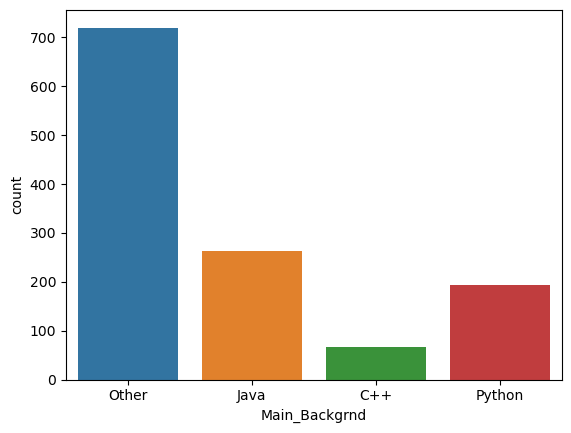

In [73]:
sns.countplot(data=df_new, x='Main_Backgrnd')

### Column: Other_Backgrnd

In [74]:
Explore(df_new, 'Other_Backgrnd')

Unique Values:  559
Null Values: 154
Type:  object


C/C++, Javascript / Typescript, Go, AWS, Docker                                                   1
Python, C/C++, Azure, Docker                                                                      1
Swift, AWS                                                                                        1
Python, C/C++, Javascript / Typescript, Go                                                        1
C/C++, SQL, Google Cloud, Docker                                                                  1
Javascript / Typescript, SQL, AWS, Google Cloud, Kubernetes, Docker                               1
Java / Scala, SQL, AWS, Azure                                                                     1
Python, C/C++, Docker, Tensorflow, PyTorch                                                        1
Javascript / Typescript, R, SQL, Google Cloud                                                     1
C/C++, Javascript / Typescript                                                                    1


In [75]:
df_new['Other_Backgrnd'].value_counts().head(25)

Javascript / Typescript                      43
Python                                       37
SQL                                          31
AWS, Docker                                  16
Kotlin                                       15
Python, SQL                                  13
C/C++                                        13
Swift                                        13
Javascript / Typescript, SQL, AWS, Docker    12
Kotlin, Java / Scala                         10
Python, C/C++                                10
Java / Scala                                  9
PHP                                           9
.NET                                          8
Python, SQL, AWS, Kubernetes, Docker          8
SQL, AWS, Docker                              8
Python, C/C++, Docker                         8
Java / Scala, SQL                             8
AWS                                           7
Javascript / Typescript, AWS, Docker          7
Kubernetes, Docker                      

In [76]:
# fill null values with the 50/50
fill_by_Mostpop_secndPop(df_new, 'Other_Backgrnd')

Null Values: 0


In [77]:
# Using Akeems solution from class problem demo:
def replace_low_freq(data, col, threshold=10, replacement='Other'): # using threshold at 10 because value_counts after 10 go crazy
    value_counts=data[col].value_counts()
    to_remove=value_counts[value_counts <= threshold].index
    tmp=data[col].replace(to_replace=to_remove, value=replacement)
    return tmp

df_new['Other_Backgrnd']=replace_low_freq(df_new, 'Other_Backgrnd', 10, 'Other')
df_new['Other_Backgrnd'].value_counts()
#print(df_new['Other_Backgrnd'].isnull().sum())

Other                                        896
Javascript / Typescript                      120
Python                                       114
SQL                                           31
AWS, Docker                                   16
Kotlin                                        15
C/C++                                         13
Swift                                         13
Python, SQL                                   13
Javascript / Typescript, SQL, AWS, Docker     12
Name: Other_Backgrnd, dtype: int64

<AxesSubplot:xlabel='Other_Backgrnd', ylabel='count'>

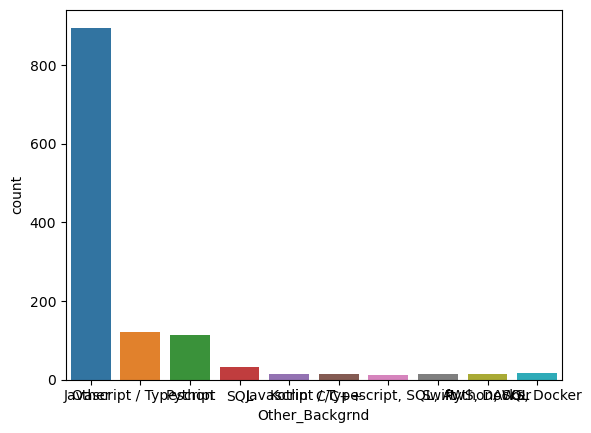

In [78]:
sns.countplot(data=df_new, x='Other_Backgrnd')

### Column: Vaca_days

In [79]:
Explore(df_new, 'Vac_days')

Unique Values:  44
Null Values: 66
Type:  object


30 in contract (but theoretically unlimited)    1
60                                              1
34                                              1
39                                              1
37                                              1
5                                               1
1                                               1
37.5                                            1
24 labour days                                  1
23+                                             1
(no idea)                                       1
50                                              1
38                                              1
365                                             1
~25                                             1
3                                               1
16                                              1
Unlimited                                       1
10                                              1
12                                              2


In [80]:
convert_to_Num(df_new, 'Vac_days')

Null Values in Vac_days:  79
float64


(None, None)

In [81]:
print(df_new['Vac_days'].mean())
print(df_new['Vac_days'].median())
print(df_new['Vac_days'].mode()[0])

28.30455326460481
28.0
30.0


In [82]:
# According to Google in Germany they have between 25-30 days of allowable vavacation days.
# Hence we will use the median value of 28 days for this example. 
fill_Null_median(df_new, 'Vac_days')

Null vales in Vac_days:  0


<AxesSubplot:xlabel='Vac_days', ylabel='Count'>

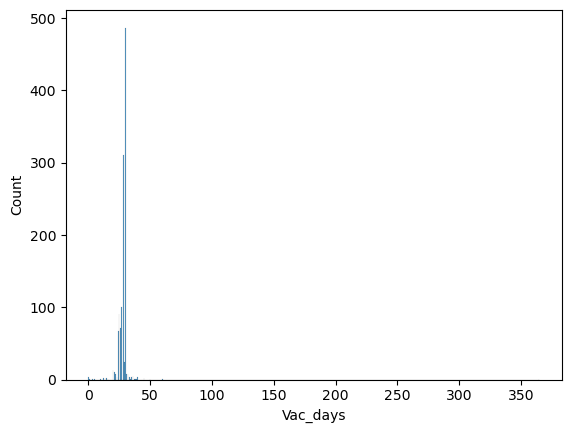

In [83]:
sns.histplot(data=df_new, x='Vac_days')

### Column: Empl_Status

In [84]:
Explore(df_new, 'Empl_Status')

Unique Values:  11
Null Values: 16
Type:  object


Company Director                                                                      1
working student                                                                       1
Working Student                                                                       1
Full-time position, part-time position, & self-employed (freelancing, tutoring)       1
Intern                                                                                1
full-time, but 32 hours per week (it was my request, I'm a student)                   1
Werkstudent                                                                           1
Founder                                                                               3
Part-time employee                                                                    8
Self-employed (freelancer)                                                           25
Full-time employee                                                                 1184
Name: Empl_Status, dtype: int64

In [85]:
df_new['Empl_Status'].value_counts().head(25)

Full-time employee                                                                 1184
Self-employed (freelancer)                                                           25
Part-time employee                                                                    8
Founder                                                                               3
Company Director                                                                      1
working student                                                                       1
Working Student                                                                       1
Full-time position, part-time position, & self-employed (freelancing, tutoring)       1
Intern                                                                                1
full-time, but 32 hours per week (it was my request, I'm a student)                   1
Werkstudent                                                                           1
Name: Empl_Status, dtype: int64

In [86]:
def map_function2(value):
    if value in ['Full-time employee', 'Founder', 'Company Director', "full-time, but 32 hours per week (it was my request, I'm a student)", 'Intern']:
        return "Full_time"
    elif value in ["Self-employed (freelancer)"]:
        return "Self_employed"
    elif value in ["working student", 'Werkstudent', 'Part-time employee', ]:
        return "Part_time"
    else:
        return "Other"

df_new["Empl_Status"] = df_new["Empl_Status"].map(map_function2)

In [87]:
df_new['Empl_Status'].value_counts()

Full_time        1190
Self_employed      25
Other              18
Part_time          10
Name: Empl_Status, dtype: int64

<AxesSubplot:xlabel='Empl_Status', ylabel='count'>

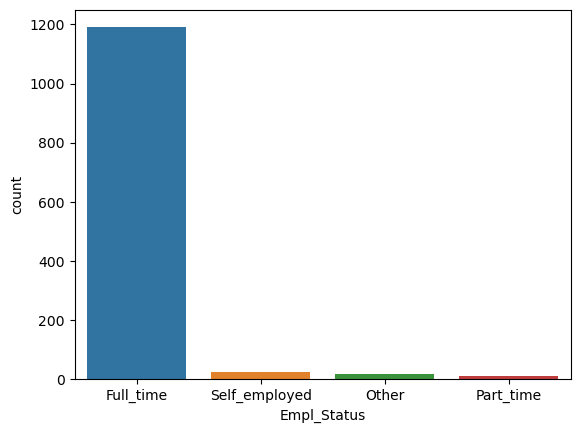

In [88]:
sns.countplot(data=df_new, x='Empl_Status')

### Column: Сontract_duration

In [89]:
Explore(df_new, 'Contract_duration')

Unique Values:  2
Null Values: 26
Type:  object


Temporary contract      63
Unlimited contract    1154
Name: Contract_duration, dtype: int64

In [90]:
fill_Null_mode(df_new, 'Contract_duration')

Null vales in Contract_duration:  0


<AxesSubplot:xlabel='Contract_duration', ylabel='count'>

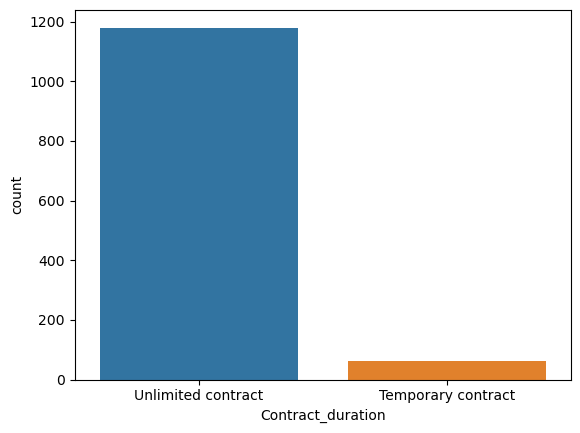

In [91]:
sns.countplot(data=df_new, x='Contract_duration')

### Column: Main_Work_Lang

In [92]:
Explore(df_new, 'Main_Work_Lang')

Unique Values:  14
Null Values: 15
Type:  object


50/50                    1
Deuglisch                1
French                   1
both                     1
Russian, English         1
English and German       2
Polish                   2
Русский                  2
Czech                    2
Italian                  3
Spanish                  3
Russian                 12
German                 185
English               1012
Name: Main_Work_Lang, dtype: int64

In [93]:
# Here since English and German are he two most popular, we can use the 50/50 fill method.
fill_by_Mostpop_secndPop(df_new, 'Main_Work_Lang')

Null Values: 0


In [94]:
def map_function3(value):
    if value in ['English', 'English and German', "Russian, English"]:
        return "English"
    elif value in ["Deuglisch", 'German']:
        return "German"
    else:
        return "Other"

df_new["Main_Work_Lang"] = df_new["Main_Work_Lang"].map(map_function3)

In [95]:
df_new['Main_Work_Lang'].value_counts()

English    1022
German      194
Other        27
Name: Main_Work_Lang, dtype: int64

<AxesSubplot:xlabel='Main_Work_Lang', ylabel='count'>

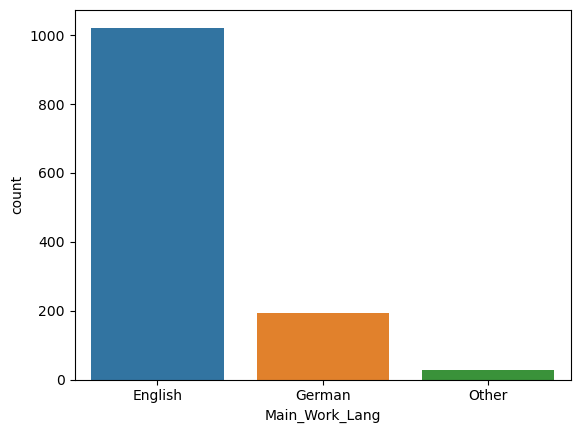

In [96]:
sns.countplot(data=df_new, x='Main_Work_Lang')

### Column: Company size

In [97]:
Explore(df_new, 'Company_size')

Unique Values:  5
Null Values: 17
Type:  object


up to 10     58
51-100      147
11-50       173
101-1000    402
1000+       446
Name: Company_size, dtype: int64

In [98]:
fill_by_Mostpop_secndPop(df_new, 'Company_size')

Null Values: 0


In [99]:
# Function to map Values to reduce the value_counts()
def map_function4(value):
    if value in ['up to 10', '11-50']:
        return "Small"
    elif value in ['51-100']:
        return "Medium"
    elif value in ['101-1000', '1000+']:
        return "Large"

df_new["Company_size"] = df_new["Company_size"].map(map_function4)

In [100]:
# FOR the sake of PRACTICE.......
# We can maybe re categorize this to VSmall, Small, Medium, Large and Huge
#df_new['Company_size']=df_new['Company_size'].map({'up to 10':'VSmall', '11-50':'Small', '51-100':'Medium', '101-1000':'Large', '1000+':'Huge'})
#df_new['Company_size'].value_counts().nsmallest(n=30)

In [101]:
df_new['Company_size'].value_counts()

Large     865
Small     231
Medium    147
Name: Company_size, dtype: int64

<AxesSubplot:xlabel='Company_size', ylabel='count'>

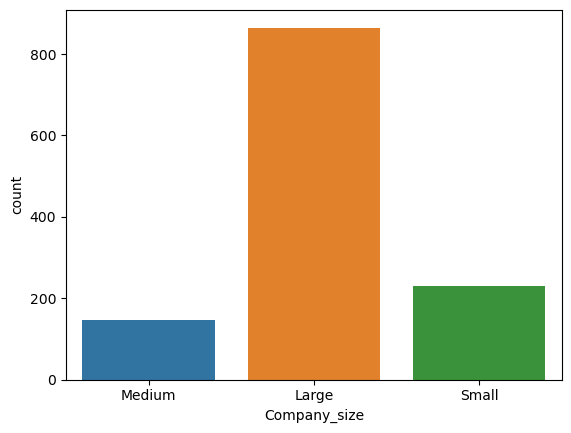

In [102]:
sns.countplot(data=df_new, x='Company_size')

### Column: Company type

In [103]:
Explore(df_new, 'Company_type')

Unique Values:  62
Null Values: 24
Type:  object


Non-tech retail                                                             1
Research institute                                                          1
Retail                                                                      1
Outsourse                                                                   1
Ecommerce                                                                   1
E-Commerce                                                                  1
Semiconductor                                                               1
Automotive                                                                  1
Institute                                                                   1
Old industry                                                                1
Handel                                                                      1
FAANG                                                                       1
Consulting and Product                                          

In [104]:
df_new['Company_type'].value_counts()

Product                756
Startup                249
Consulting / Agency    141
Bank                     5
Media                    3
                      ... 
Publisher                1
Energy                   1
Enterprise               1
service                  1
eCommerce                1
Name: Company_type, Length: 62, dtype: int64

In [105]:
# Use the 50/50 fill method
fill_by_Mostpop_secndPop(df_new, 'Company_type')

Null Values: 0


In [106]:
# Function to map Values to reduce the value_counts()
def map_function4(value):
    if value in ['Product']:
        return "Product"
    elif value in ['Startup']:
        return "Startup"
    elif value in ['Consulting / Agency']:
        return "Consulting-Agency"
    else:
        return 'Other'

df_new["Company_type"] = df_new["Company_type"].map(map_function4)


In [107]:
df_new['Company_type'].value_counts()

Product              768
Startup              261
Consulting-Agency    141
Other                 73
Name: Company_type, dtype: int64

<AxesSubplot:xlabel='Company_type', ylabel='count'>

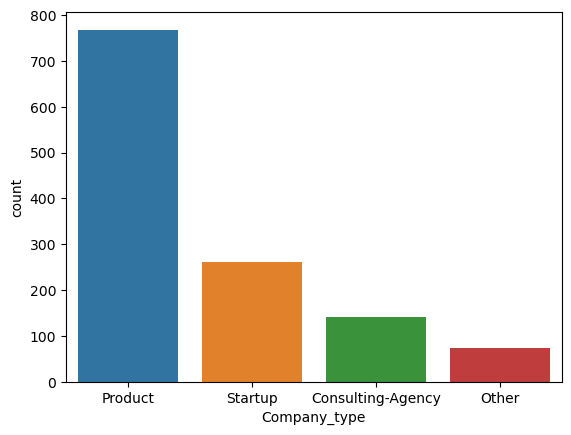

In [108]:
sns.countplot(data=df_new, x='Company_type')

Results of Data Wrangling to clean the datarame

In [109]:
display(df_new.isnull().sum())
print(df_new.shape)

Age                  0
Gender               0
City                 0
Position             0
Total_yrs_Exp        0
German_Exp           0
Seniority_level      0
Main_Backgrnd        0
Other_Backgrnd       0
Vac_days             0
Empl_Status          0
Contract_duration    0
Main_Work_Lang       0
Company_size         0
Company_type         0
Target               0
dtype: int64

(1243, 16)


In [110]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1243 non-null   float64
 1   Gender             1243 non-null   object 
 2   City               1243 non-null   object 
 3   Position           1243 non-null   object 
 4   Total_yrs_Exp      1243 non-null   float64
 5   German_Exp         1243 non-null   float64
 6   Seniority_level    1243 non-null   object 
 7   Main_Backgrnd      1243 non-null   object 
 8   Other_Backgrnd     1243 non-null   object 
 9   Vac_days           1243 non-null   float64
 10  Empl_Status        1243 non-null   object 
 11  Contract_duration  1243 non-null   object 
 12  Main_Work_Lang     1243 non-null   object 
 13  Company_size       1243 non-null   object 
 14  Company_type       1243 non-null   object 
 15  Target             1243 non-null   float64
dtypes: float64(5), object(11

In [111]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1243.0,32.489139,5.583692,21.0,29.00,32.0,35.0,69.0
Total_yrs_Exp,1243.0,9.044608,11.823958,0.0,5.00,8.0,12.0,383.0
German_Exp,1243.0,3.694690,3.561588,0.0,1.25,3.0,5.0,30.0
Vac_days,1243.0,28.285197,10.201360,0.0,27.00,28.0,30.0,365.0
Target,1243.0,83479.288479,50622.164524,10001.0,60000.00,73000.0,90000.0,1240000.0


<AxesSubplot:>

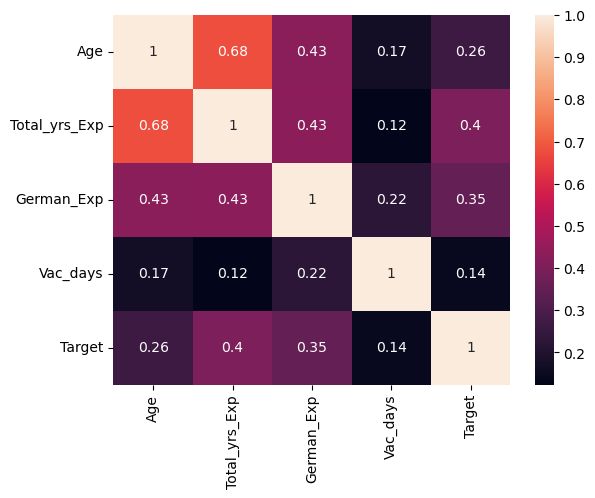

In [112]:
sns.heatmap(df_new.corr(method='spearman'), annot=True)

In [113]:
df_new.to_csv('Clean_File.csv')

In [114]:
# View the Numerical Columns
print(df_new.select_dtypes(include=[np.number]).columns) # Numerical Columns

Index(['Age', 'Total_yrs_Exp', 'German_Exp', 'Vac_days', 'Target'], dtype='object')


In [115]:
# View the Categorical Columns
print(df_new.select_dtypes(exclude=[np.number]).columns) # Categorical Columns

Index(['Gender', 'City', 'Position', 'Seniority_level', 'Main_Backgrnd',
       'Other_Backgrnd', 'Empl_Status', 'Contract_duration', 'Main_Work_Lang',
       'Company_size', 'Company_type'],
      dtype='object')


In [116]:
# Convert Object columns to Categorical Columns
for col in (df_new.select_dtypes(exclude=[np.number]).columns):
    df_new[col]=df_new[col].astype('category')

    
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                1243 non-null   float64 
 1   Gender             1243 non-null   category
 2   City               1243 non-null   category
 3   Position           1243 non-null   category
 4   Total_yrs_Exp      1243 non-null   float64 
 5   German_Exp         1243 non-null   float64 
 6   Seniority_level    1243 non-null   category
 7   Main_Backgrnd      1243 non-null   category
 8   Other_Backgrnd     1243 non-null   category
 9   Vac_days           1243 non-null   float64 
 10  Empl_Status        1243 non-null   category
 11  Contract_duration  1243 non-null   category
 12  Main_Work_Lang     1243 non-null   category
 13  Company_size       1243 non-null   category
 14  Company_type       1243 non-null   category
 15  Target             1243 non-null   float64 
dtypes: cat

In [117]:
df_new.to_csv('Clean_File.csv')

# Part 2: Regression
